# Final Project Part 3 - Cheri Hung


In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
import seaborn as sns
from pandas.io import sql
from math import sqrt
from scipy.stats import uniform as sp_rand
import sqlite3
from hung_func import *
from sklearn import feature_selection, linear_model, metrics, model_selection, cross_validation
from sklearn.model_selection import RandomizedSearchCV
plt.style.use('ggplot')

wd = 'assets/'
db_conn = sqlite3.connect(wd+'dev_hung.db')
print db_conn

/Users/cherihung/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## I. Exploratory Analysis

### Dataset: Variance Quantity
**Join various tables from a SQLite DB to create a useful dataframe. This dataset is to show the _VarianceQty_ or difference between expected quantity to have on hand at the end of a period and actual quantity left. The _VarianceQty_ can be both positive or negative.**

In [2]:
#create dataframe of the main dataset of a SQL View 
df_IvAC_raw = sql.read_sql(
    'SELECT V.ProductID, COUNT(V.InventoryID), I.ProductDescription, SUM(V.VarianceQty), \
    SUM(V.ActualQty), SUM(V.IdealQty), D.Date, IC.CategoryID, C.Category, I.ProductType, D.StoreID \
  FROM [InventoryDates] D \
  INNER JOIN [IVActualC] V ON D.InventoryId = V.InventoryID \
  INNER JOIN [Ingredients] I ON I.ProductID = V.ProductID \
  JOIN [ItemCategories] IC ON IC.ProductID = V.ProductID \
  JOIN [Categories] C ON C.CategoryID = IC.CategoryID \
  GROUP BY V.ProductID', con=db_conn)

In [3]:
#df_IvAC_raw = sql.read_sql('SELECT * FROM vw_IVActualC_inventoryTotal', con=db_conn)
df_IvAC = df_IvAC_raw.dropna()
df_IvAC.head(1)

ProductID  COUNT(V.InventoryID) ProductDescription  SUM(V.VarianceQty)  \
0         24                    20     Tomato, Cherry               951.0   

   SUM(V.ActualQty)  SUM(V.IdealQty)           Date  CategoryID Category  \
0            1798.0            900.0  11/16/16 0:00           2  Produce   

  ProductType  StoreID  
0           2        6

In [4]:
#change column names to be readable
df_IvAC.columns = ['ProductID', 'TotalOrders', 'Name', 'VarianceQty', 'ActualQty', 'IdealQty', 'Date', 'CategoryID', 'Category', 'ProductType', 'StoreID']

In [5]:
df_IvAC.head(3)

ProductID  TotalOrders                            Name  VarianceQty  \
0         24           20                  Tomato, Cherry      951.000   
1         26            6                    Tito's Vodka      -66.556   
2         37            3  Sutter Home Cabernet Sauvignon       10.144   

   ActualQty  IdealQty           Date  CategoryID Category ProductType  \
0   1798.000     900.0  11/16/16 0:00           2  Produce           2   
1    -62.556       4.0  12/16/16 0:00          11   Liquor           1   
2     10.144       0.0  11/28/16 0:00          10     Wine           1   

   StoreID  
0        6  
1       15  
2       15

#### This original DB table shows one record for eacn inventory order for a item. The joined dataframe above rolls up the records of the same item (ProductID) and calculate the sum of their _VarianceQty_ and count the number of its occurances as _TotalOrders_.

**Below is the data dictionary**

| Variable | Description | Type of Variable |
|----------|:-------------:|------:|
| ProductID |Identifying ingredient ID | discrete numerical ID |
| TotalOrders |number of inventory orders placed | continous numerical |
| Name | Ingredient name | text |
| VarianceQty | Difference between ActualQty and IdealQty as calculated by the system | continous numerical |
| ActualQty | Actual quantity of the item left at the end of the period | continous numerical |
| IdealQty | How much ideally should be left at the end of the period | continous numerical |
| Date | Inventory order date | discrete numerical ID |
| CategoryID | category id | discrete numerical ID |
| Category | category the ingredient belongs to | text |
| ProductType | a general product type. 1=liquor, 2=food, 3=other, 4=merchandise | discrete numerical ID |
| StoreID | store that data is associated with | discrete numerical ID |


#### To focus our analysis, let's focus on only Food items (ProductType = 2)

### Food-only Dataset for this Analysis

In [6]:
ivac_foods = df_IvAC[df_IvAC['ProductType'] == '2']
ivac_foods.head()

ProductID  TotalOrders                    Name  VarianceQty  ActualQty  \
0         24           20          Tomato, Cherry      951.000   1798.000   
3         38           17             Sugar, Bulk      658.030    990.000   
4         40           17    Strawberries, Frozen     -337.440    260.000   
5         68            8  Spice, Flour Seasoning        2.324     15.336   
6         80           19              Sour Cream      785.200   2959.200   

   IdealQty           Date  CategoryID    Category ProductType  StoreID  
0   900.000  11/16/16 0:00           2     Produce           2        6  
3   331.970  10/27/16 0:00           4  Other Food           2        6  
4   597.440  10/27/16 0:00           4  Other Food           2        6  
5   229.663   3/10/17 0:00           4  Other Food           2        5  
6  2219.000   12/2/16 0:00           3       Dairy           2        7

In [7]:
ivac_foods.describe()

ProductID  TotalOrders    VarianceQty     ActualQty      IdealQty  \
count   49.000000    49.000000      49.000000  4.900000e+01  4.900000e+01   
mean   374.734694    95.061224   15390.754918  9.486636e+04  8.919493e+04   
std    145.458868   141.065648   50009.148872  3.510533e+05  3.073961e+05   
min     24.000000     2.000000   -6576.000000 -2.816000e+03  5.134000e+01   
25%    292.000000    17.000000      -5.998000  8.320000e+02  8.780000e+02   
50%    407.000000    36.000000     674.550000  4.292000e+03  6.219500e+03   
75%    481.000000   103.000000    7498.912000  2.979288e+04  2.849800e+04   
max    533.000000   671.000000  320904.181000  2.295302e+06  1.999503e+06   

       CategoryID    StoreID  
count   49.000000  49.000000  
mean     3.653061  11.428571  
std      2.890725   5.103104  
min      1.000000   4.000000  
25%      2.000000   6.000000  
50%      4.000000  13.000000  
75%      4.000000  15.000000  
max     20.000000  19.000000

#### From the summary above, we see a pretty big standard deviation and min/max range in our data. This tells us we likely need to transform our data to normalize it. And that our data probably has key outliers. 

**Also, maybe we can pick a category to focus our analysis?**

### Food Categories
#### Let's take a look at the data by category in the Food (product type 2) group. And see if we can focus on one category since our dataset presents such a wide range of values.

In [8]:
df_categories = sql.read_sql('SELECT CategoryID, Category FROM Categories', con=db_conn)
df_categories

CategoryID      Category
0           0  NOT ASSIGNED
1           1          Meat
2           2       Produce
3           3         Dairy
4           4    Other Food
5           5       Seafood
6           6       Poultry
7           7         Bread
8           8   NA Beverage
9           9          Beer
10         10          Wine
11         11        Liquor
12         12     Other-CGS
13         13        Retail
14         14    Smallwares
15         15      Chemical
16         17         Other
17         18         Paper
18         19      Uniforms
19         20      Crawfish
20         \n          None

In [9]:
ivac_foods_grouped = ivac_foods.groupby('CategoryID')
ivac_foods_grouped.size()

CategoryID
1     10
2      6
3      7
4     15
5      5
6      4
7      1
20     1
dtype: int64

#### Well, no one category has an overwhelmingly larger number items than others. And given our dataset has a relative samll sample size with the roll-uped data. Let's no weed out any categories just yet. 

### Variance Quantity - All food items

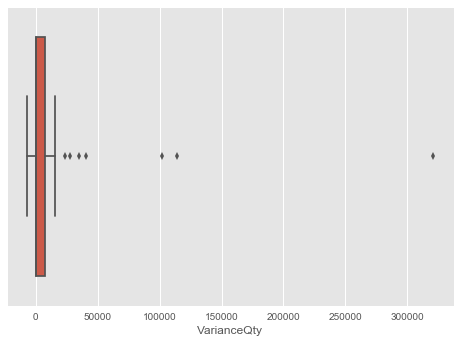

In [10]:
#variance quantity of the main dataset
varQty = ivac_foods.VarianceQty
sns.boxplot(varQty)

#### a few significant outliers. Let's see what they are.

In [11]:
ivac_foods[ivac_foods.VarianceQty > 100000]

ProductID  TotalOrders                  Name  VarianceQty   ActualQty  \
47        399          287   Fries, 5/16" Russet   320904.181  2295302.40   
64        458          484  Chicken, Tenderloins   102301.850   713684.40   
65        459          671      Chicken, Breasts   114368.310   681745.12   

       IdealQty          Date  CategoryID    Category ProductType  StoreID  
47  1999503.439  3/17/17 0:00           4  Other Food           2       15  
64   628085.210  3/17/17 0:00           6     Poultry           2       15  
65   615584.810  3/24/17 0:00           6     Poultry           2        7

#### The outliers are legitimate food items. They appear to be very highly used items with a large quantity value. So we will likely have to log transform the data later.

#### Let's look at colinearity

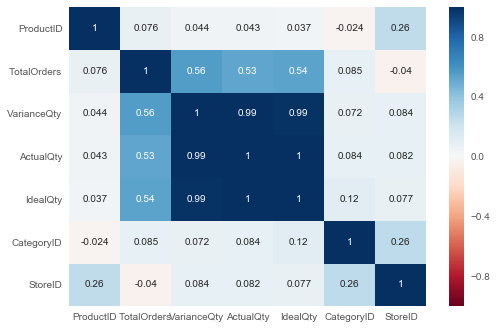

In [12]:
sns.heatmap(ivac_foods.corr(), annot=True, cmap='RdBu')

**So it appears to have a moderate level of colinearity between VarianceQty and TotalOrders. That's good.** And it's expected that ActualQty and IdealQty would have near perfect colinearity to VarianceQty as the later is the difference of the two.

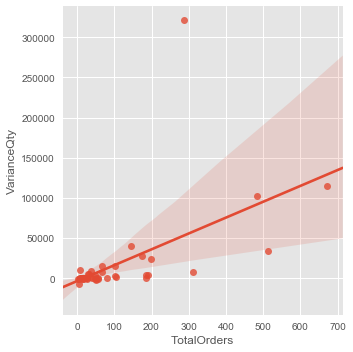

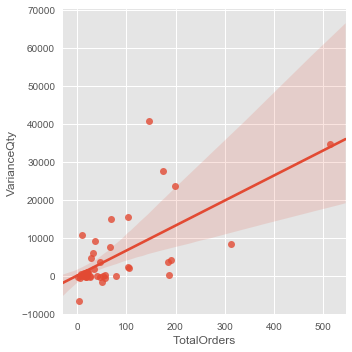

In [13]:
ivac_foods_pos = ivac_foods[ivac_foods['VarianceQty'] < 50000] #secondary dataset that removes the dataset as a test
x = 'TotalOrders'
y = 'VarianceQty'
print sns.lmplot(x, y, ivac_foods)
print sns.lmplot(x, y, ivac_foods_pos)

In [14]:
log_columns = ['VarianceQty', 'TotalOrders', 'ActualQty', 'IdealQty']
log_ivac_foods = log_transform(ivac_foods, log_columns)
log_ivac_foods_pos = log_transform(ivac_foods_pos, log_columns)
#print log_ivac_foods.describe()
#print log_ivac_foods_pos.describe()

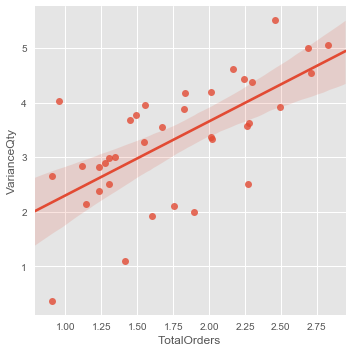

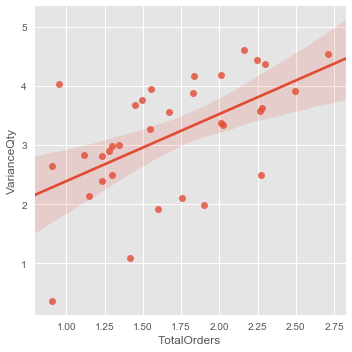

In [15]:
print sns.lmplot(x, y, log_ivac_foods)
print sns.lmplot(x, y, log_ivac_foods_pos)

### Variance Quantity - Poultry Only
Let's see if it's worth basing the model just on Poultry category.

        ProductID  TotalOrders    VarianceQty      ActualQty       IdealQty  \
count    4.000000     4.000000       4.000000       4.000000       4.000000   
mean   457.500000   338.250000   55340.635000  356465.600000  318097.005000   
std      1.290994   296.090499   61410.286263  394435.867543  350953.489496   
min    456.000000     8.000000     445.500000     640.000000     220.000000   
25%    456.750000   144.500000    3296.535000   22504.660000   21428.500000   
50%    457.500000   337.000000   53274.365000  355769.000000  322041.405000   
75%    458.250000   530.750000  105318.465000  689729.940000  618709.910000   
max    459.000000   671.000000  114368.310000  713684.400000  628085.210000   

       CategoryID    StoreID  
count         4.0   4.000000  
mean          6.0  13.250000  
std           0.0   4.193249  
min           6.0   7.000000  
25%           6.0  13.000000  
50%           6.0  15.000000  
75%           6.0  15.250000  
max           6.0  16.000000  
Axes(0.12

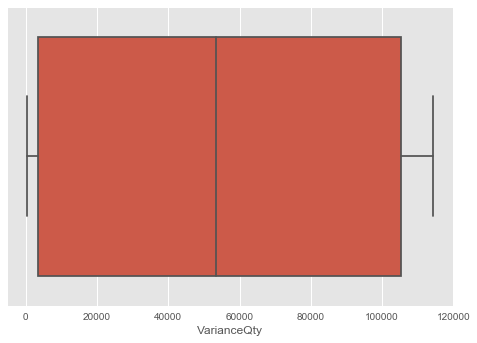

In [16]:
ivac_poultry = ivac_foods[ivac_foods['CategoryID'] == 6]
print ivac_poultry.describe()
varQty_poultry = ivac_poultry.VarianceQty
print sns.boxplot(ivac_poultry.VarianceQty)

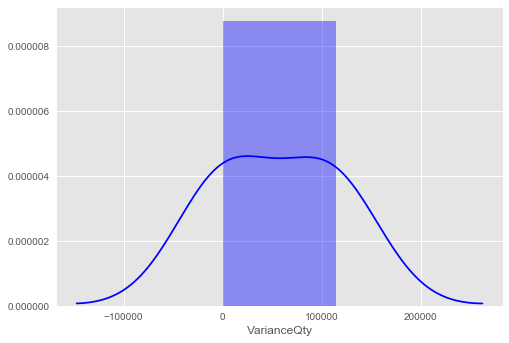

In [17]:
sns.distplot(varQty_poultry, color='blue', norm_hist=True)

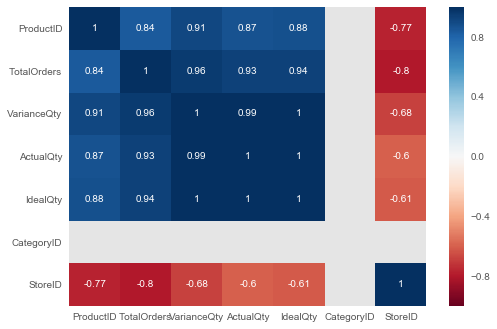

In [18]:
sns.heatmap(ivac_poultry.corr(), annot=True, cmap='RdBu')

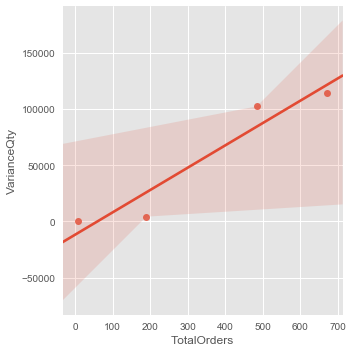

In [19]:
sns.lmplot(x, y, ivac_poultry)

In [20]:
log_ivac_poultry = log_transform(ivac_poultry, log_columns)
log_ivac_poultry.describe()

ProductID  TotalOrders  VarianceQty  ActualQty  IdealQty  CategoryID  \
count    4.000000     4.000000     4.000000   4.000000  4.000000         4.0   
mean   457.500000     2.173353     4.086277   4.741855  4.596136         6.0   
std      1.290994     0.878103     1.165339   1.442942  1.629655         0.0   
min    456.000000     0.903090     2.648848   2.806180  2.342423         6.0   
25%    456.750000     1.934838     3.383264   4.057129  3.926716         6.0   
50%    457.500000     2.481799     4.318977   5.153867  5.122051         6.0   
75%    458.250000     2.720315     5.021989   5.838593  5.791471         6.0   
max    459.000000     2.826723     5.058306   5.853506  5.798019         6.0   

         StoreID  
count   4.000000  
mean   13.250000  
std     4.193249  
min     7.000000  
25%    13.000000  
50%    15.000000  
75%    15.250000  
max    16.000000

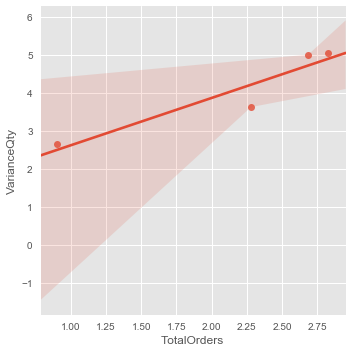

In [21]:
sns.lmplot(x, y, log_ivac_poultry)

**While the distribution of Poultry data looks better. It is just too few data samples (4) to be used as modeling data. And its linear regression plot does not look any more useful than using the whole dataset** So we will not be basing our analysis on category.

### Regression Model on non-normalized data

P Values: [  3.25605350e-05]
Coefficients: [ 197.38732786]
y-intercept: -3373.12616655
R-2: 0.310014598267
MSE: 1690378600.03
RMSE: 41114.2140875


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

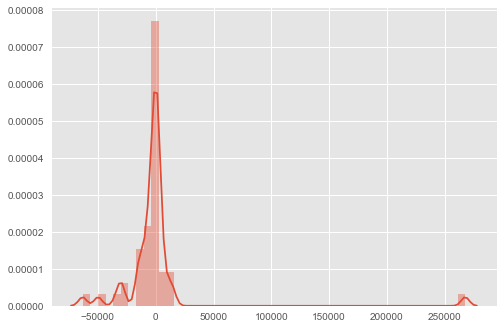

In [22]:
lmX = ivac_foods[[x]]
lmy = ivac_foods[y]
#uncomment these and use to test if excluding outliers help. It didn't
#lmX = ivac_foods_pos[[x]]
#lmy = ivac_foods_pos[y]

lm_int = linear_model.LinearRegression()
get_linear_model_metrics(lmX, lmy, lm_int)

### Regression Model based on Logged Transform Data

P Values: [  1.17938190e-05]
Coefficients: [ 1.35786861]
y-intercept: 0.940505779505
R-2: 0.435918085351
MSE: 0.684267962081
RMSE: 0.827204909367


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

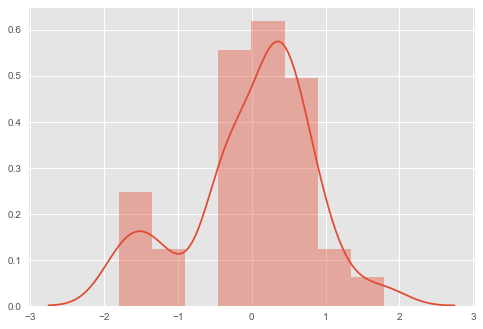

In [24]:
logX = log_ivac_foods[[x]]
logy = log_ivac_foods[y]
#logX = log_ivac_foods_pos[[x]]
#logy = log_ivac_foods_pos[y]

lm = linear_model.LinearRegression()
get_linear_model_metrics(logX, logy, lm)

### Try Different Estimators to Find a Better Regression Model
Use Logged Transform data because it performed better

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
P Values: [  1.17938190e-05]
Coefficients: [ 1.23796495]
y-intercept: 1.15194409128
R-2: 0.43251906123
MSE: 0.688391198882
RMSE: 0.829693436687

HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=100,
        tol=1e-05, warm_start=False)
P Values: [  1.17938190e-05]
Coefficients: [ 1.29949423]
y-intercept: 1.16273483421
R-2: 0.42338144698
MSE: 0.699475717847
RMSE: 0.836346649331

RidgeCV(alphas=array([  1.00000e-10,   1.00000e-09,   1.00000e-08,   1.00000e-07,
         1.00000e-06,   1.00000e-05,   1.00000e-04,   1.00000e-03,
         1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04,   1.00000e+05,
         1.00000e+06,   1.00000e+07,   1.00000e+08,   1.00000e+09,
         1.00000e+10]),
    cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring='neg_mean_squar

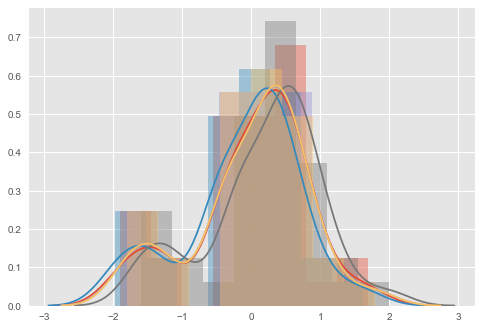

In [84]:
alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
epsilons = np.arange(1.1, 1.5, 1.8)
n_iter = np.arange(5, 8, 9)

param_grid = {
    'fit_intercept': [True, False],
    'alpha': alphas
}

#without fine tuning params, let's see how each do on the baseline
estimators = [
    linear_model.Ridge(),
    linear_model.HuberRegressor(), #Suppose to be good for dataset with outliers
    linear_model.RidgeCV(scoring='neg_mean_squared_error', alphas=(np.logspace(-10, 10, 21))),
    linear_model.SGDRegressor(),
    linear_model.LinearRegression()
]

for est in estimators:
    print est
    get_linear_model_metrics(logX, logy, est)
    print

**No other regression model appears to help tremendously our model's fit. The Ridge() does better slightly. Let's use that for optimization and evaluation**

### Tune using Ridge as Estimator

In [74]:
gs = model_selection.GridSearchCV(
    estimator=linear_model.Ridge(),
    param_grid=param_grid,
    # Default score is R-squared
    scoring='neg_mean_squared_error',
    cv = 5)

gs.fit(logX, logy)
print gs.best_estimator_
print gs.best_params_
print -gs.best_score_

Ridge(alpha=0.10000000000000001, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)
{'alpha': 0.10000000000000001, 'fit_intercept': True}
0.902022895945


P Values: [  1.17938190e-05]
Coefficients: [ 1.34484307]
y-intercept: 0.96347503626
R-2: 0.435877972756
MSE: 0.684316621262
RMSE: 0.827234320651


Ridge(alpha=0.10000000000000001, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

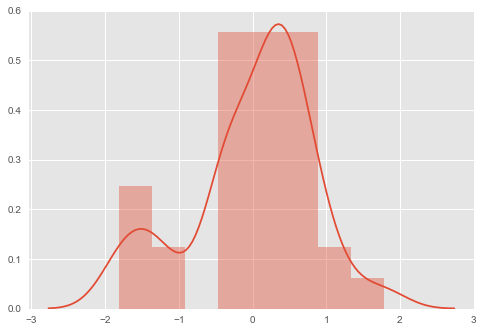

In [75]:
get_linear_model_metrics(logX, logy, gs.best_estimator_)

### Tune using SGDRegressor as Estimator

In [83]:
param_grid_sgd = {
    'fit_intercept': [True, False],
    'alpha': alphas,
    'epsilon': epsilons,
    'n_iter': n_iter
}

gsgd = model_selection.GridSearchCV(
    estimator=linear_model.SGDRegressor(),
    param_grid=param_grid_sgd,
    # Default score is R-squared
    scoring='neg_mean_squared_error',
    cv = 5)

gsgd.fit(logX, logy)
print gsgd.best_estimator_
print gsgd.best_params_
print -gsgd.best_score_

SGDRegressor(alpha=0.01, average=False, epsilon=1.1000000000000001, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False)
{'n_iter': 5, 'alpha': 0.01, 'fit_intercept': True, 'epsilon': 1.1000000000000001}
0.888561790793


P Values: [  1.17938190e-05]
Coefficients: [ 1.36027249]
y-intercept: [ 0.72983536]
R-2: 0.400787580533
MSE: 0.726883543816
RMSE: 0.852574655861


SGDRegressor(alpha=0.01, average=False, epsilon=1.1000000000000001, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False)

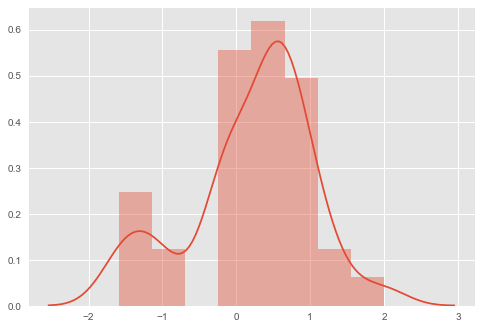

In [85]:
get_linear_model_metrics(logX, logy, gsgd.best_estimator_)

### Cross Validate Our Best-Fit Model - Ridge()

In [30]:
folds=5
kf = cross_validation.KFold(len(logX), n_folds=folds, shuffle=True)

mse_values = []
rmse_values = []
scores = []
n= 1
print "~~~~ CROSS VALIDATION each fold ~~~~"
for train_index, test_index in kf:
    lm = gs.best_estimator_.fit(logX.iloc[train_index], logy.iloc[train_index])
    mse_values.append(metrics.mean_squared_error(logy.iloc[test_index], lm.predict(logX.iloc[test_index])))
    rmse_values.append(sqrt(metrics.mean_squared_error(logy.iloc[test_index], lm.predict(logX.iloc[test_index]))))
    scores.append(lm.score(logX, logy))
    print 'Model', n
    print 'MSE:', mse_values[n-1]
    print 'RMSE:', rmse_values[n-1]
    print 'R-Squared:', scores[n-1]
    print
    n=n+1
    
print "~~~~ SUMMARY OF CROSS VALIDATION ~~~~"
print 'Mean of MSE for all folds:', np.mean(mse_values)
print 'Mean of RMSE for all folds:', np.mean(rmse_values)
print 'Mean of R-Squared for all folds:', np.mean(scores)

~~~~ CROSS VALIDATION each fold ~~~~
Model 1
MSE: 0.451878044561
RMSE: 0.672218747553
R-Squared: 0.434309256341

Model 2
MSE: 1.13262771142
RMSE: 1.06424983506
R-Squared: 0.418978986297

Model 3
MSE: 1.08016060338
RMSE: 1.039307752
R-Squared: 0.403980542602

Model 4
MSE: 0.549260332154
RMSE: 0.741120996973
R-Squared: 0.432592046081

Model 5
MSE: 1.05333147649
RMSE: 1.02631938328
R-Squared: 0.41371834676

~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 0.8534516336
Mean of RMSE for all folds: 0.908643342973
Mean of R-Squared for all folds: 0.420715835616


### So it appears we have an variance problem. Fine tuning the model did not yield much improvement.

### Next Step for this Inventory Predictor
* Get more data to help train the model
* More data will also enable us to split data up into seasons, which might mitigate some covariation problem.
* Classify the inventory pattern in a way for us to produce a classification analysis or logistic regression.
* Focus on high-volume inventory items. So we can more finely calculate the rate of order.